## Predicting House prices in Tunisia

In [4]:
import pandas as pd

import warnings 
warnings.filterwarnings(action='ignore', category=FutureWarning)


import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge


from category_encoders import OneHotEncoder

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

from ipywidgets import Dropdown, IntSlider, FloatSlider, interact

## Data Wrangling

In [5]:
def wrangle(file):
    # Read csv file to pandas Dataframe
    df = pd.read_csv(file)
    
    
    # Subset to only include houses less than €100_000
    subset_price = df['price_eur'] < 100000
    
    df = df[subset_price]
        
    # Removing the Top 10 and Bottom 10 percent of the 'area' column
    top, bottom = df['Area'].quantile([0.1, 0.9])
    subset_area = df['Area'].between(top, bottom)
    
    
    df = df[subset_area]
    
    
    # Dropping columns with more than 50% Null values
    columns = df.isnull().sum().to_dict()
    for key in columns:
        if columns[key] > df.shape[0]/2:
            df.drop(columns=[key], inplace=True)

    # Dropping categorical columns with Low or Too High cardinality
    df.drop(columns=['id'], inplace=True)
    
    # Dropping columns that can cause Leakage to the model
    df.drop(columns=['price_tnd'], inplace=True)
    
    # Dropping columns that will cause multicollinearity
    df.drop(columns=['pieces', 'room', 'bathroom', 'state', 'garden'], inplace=True)
    
    # Dropping columns that are not neccessary features for the model
    df.drop(columns=['furnished', 'elevator', 'pool', 'mountain_view', 'garage', 
                     'concierge', 'beach_view', 'air_conditioning', 'equipped_kitchen', 
                     'central_heating', 'city', 'location', 'distance_to_capital'], inplace=True)
    
    return df

In [9]:
df = wrangle('C:/Users/user/Documents/House_Price_Prediction_Model/Dataset/dataSetFull.csv')
columns = df.isnull().sum().to_dict()
for key in columns:
    if columns[key] > df.shape[0]/2:
        df.drop(columns=[key], inplace=True)
        

df.select_dtypes('object').nunique()

governorate    19
dtype: int64

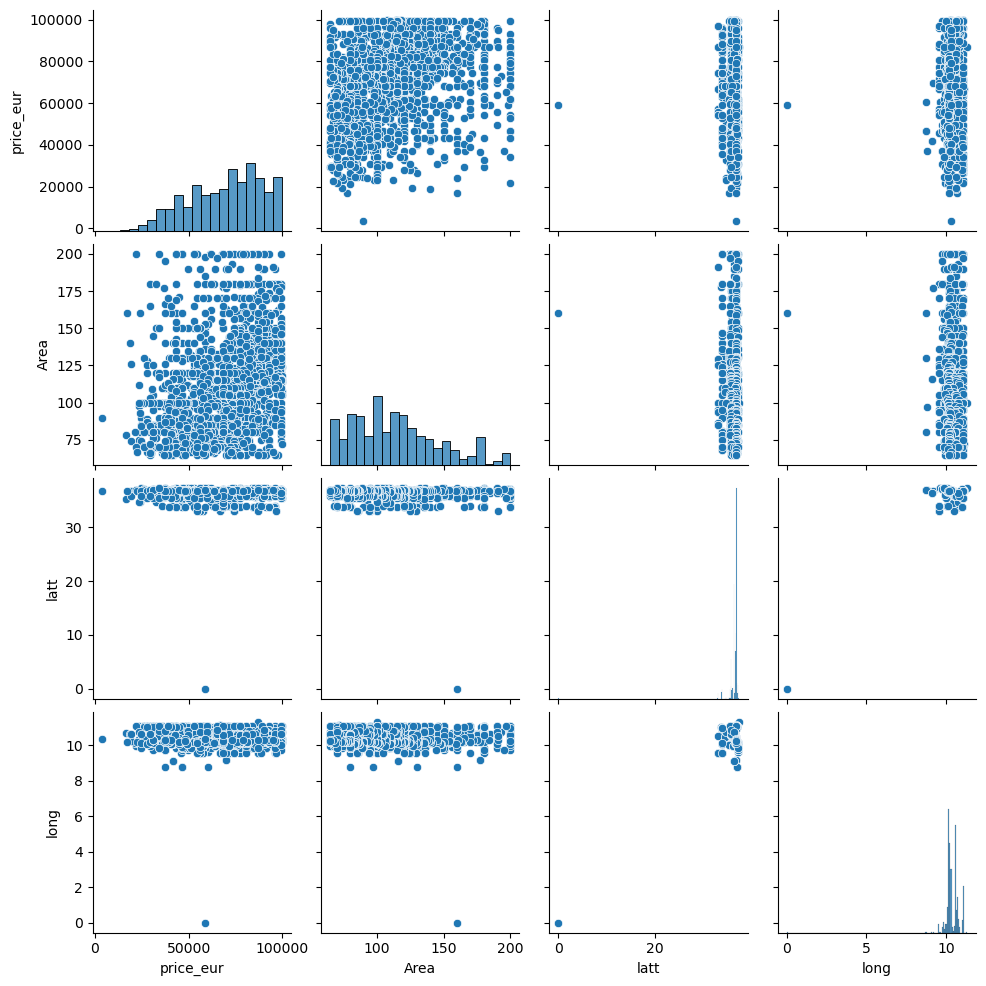

In [10]:
sns.pairplot(df)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1838 entries, 60 to 8037
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price_eur    1838 non-null   float64
 1   governorate  1838 non-null   object 
 2   Area         1838 non-null   float64
 3   latt         1833 non-null   float64
 4   long         1833 non-null   float64
dtypes: float64(4), object(1)
memory usage: 86.2+ KB


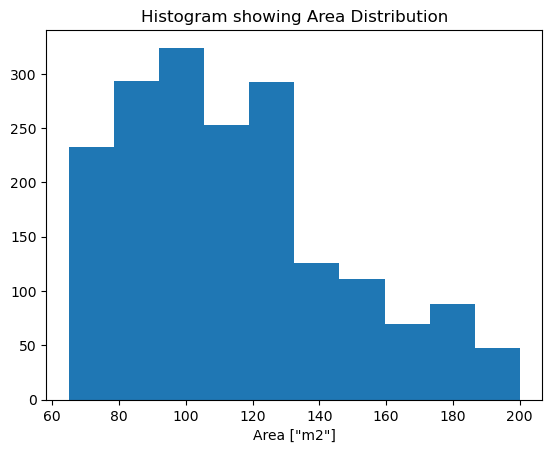

In [13]:
plt.hist(df.Area)
plt.xlabel('Area ["m2"]')
plt.title('Histogram showing Area Distribution');

In [7]:
df.head()

,price_eur,governorate,Area,latt,long
60,80600.0,Bizerte,131.0,37.130300,9.750678
138,99200.0,tunis,200.0,NaN,NaN
226,77500.0,Nabeul,180.0,36.401080,10.614570
227,68200.0,Djerba,178.0,33.782703,11.026705
230,77500.0,tunis,124.0,33.886900,9.537500


## Feature Enginnering

In [14]:
# Seperating Features natrix and Target vector

feature = ['governorate', 'Area', 'latt', 'long']
train = 'price_eur'

X = df[feature]
y = df[train]

In [15]:
# Spliting the dataset to train and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Baseline

In [16]:
# Baseline Model
y_mean = round(y_train.mean(), 2)
y_pred = [y_mean for y in y_train]

# performance of the baseline model
MAE_baseline = round(mean_absolute_error(y_pred, y_train), 2)

print(f'Mean Price: {y_mean}')
print(f'MAE Baseline: {MAE_baseline}')

Mean Price: 69232.41
MAE Baseline: 16125.51


### Iterate

In [17]:
# Instantiate the model
model = make_pipeline(
                    OneHotEncoder(use_cat_names=True),
                    SimpleImputer(),
                    Ridge())

In [18]:
# Fit the model

model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['governorate'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

### Evaluate

In [19]:
# Predict target
y_pred_train = pd.Series(model.predict(X_train))
y_pred_train.head()

0    53935.910335
1    61437.674731
2    74478.925257
3    76739.211448
4    75366.282332
dtype: float64

In [20]:
# Performance of the model

MAE_training = round(mean_absolute_error(y_train, y_pred_train), 2)
print(f'MAE training: {MAE_training}')

MAE training: 14511.32


In [21]:
# Test the model

y_pred_test = model.predict(X_test)
MAE_test = round(mean_absolute_error(y_test, y_pred_test), 2)
print(f'MAE test: {MAE_test}')

MAE test: 14702.42


In [22]:
# Obtain the coefficeints and Intercept
coefficients = pd.Series(model.named_steps['ridge'].coef_)
coefficients

intercept = model.named_steps['ridge'].intercept_
intercept

54860.81631657451

In [17]:
# Obtain feature names
features = model.named_steps['onehotencoder'].get_feature_names_out()
features

array(['governorate_Bizerte', 'governorate_Nabeul', 'governorate_tunis',
       'governorate_Ariana', 'governorate_ Sousse',
       'governorate_Monastir', 'governorate_Ben Arous',
       'governorate_La Manouba', 'governorate_Zaghouan',
       'governorate_Kébili', 'governorate_Djerba', 'governorate_Mahdia',
       'governorate_Sfax', 'governorate_Jendouba', 'governorate_Kairouan',
       'governorate_Béja', 'governorate_Gabès', 'governorate_Siliana',
       'governorate_Tataouine', 'Area', 'latt', 'long'], dtype=object)

### Create a function that takes in the Province, Area, Lattitude and Longitude and returns House Price prediction

In [23]:

def make_prediction(province, surface_area_in_m2, lat, lon):
    data = {
        'governorate': province,
        'Area': surface_area_in_m2,
        'latt': lat,
        'long': lon
    }
    
    X = pd.DataFrame(data, index=[0])
    
    price = model.predict(X)
    
    return f'Predicted house Price: €{round(price[0], 2)}'

In [24]:
price = make_prediction('Mahdia', 60, 4.24535, 2.453)
price

'Predicted house Price: €53904.83'

### Communicating Result 

In [25]:
interact(
    make_prediction,
    surface_area_in_m2=IntSlider(
        value=X_train['Area'].mean(),
        min=X_train['Area'].min(),
        max=X_train['Area'].max()
    ),
         
     lat=FloatSlider(
         value=X_train['latt'].mean(),
         min=X_train['latt'].min(),
         max=X_train['latt'].max()
    ),
         
     lon=FloatSlider(
         value=X_train['long'].mean(),
         min=X_train['long'].min(),
         max=X_train['long'].max()
     ),
    province=Dropdown(options=X_train['governorate'].unique())
);

In [ ]:
# Visualizing the Regression Line

# Scatter plot of the actual data
plt.scatter(X_test, y_test, color='blue', label='Actual Prices')

# Plotting the regression line
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Regression Line')

# Adding labels and title
plt.xlabel('Feature' )
plt.ylabel('Target')
plt.title('Regression Line for Predicting House Prices in Tunisia')
plt.legend()

# Show the plot
plt.show()